# Lesson 6 "Differential Privacy for Deep Learning" project

## Scenario description 


Training set: 60000 labeled images. This will be split in 20 slices of 3000 labeled images to generate the private models.
Test set: 10000 images.
The test set will have 2 purposes:
 - To help measure the training accuracy (using its labels for this)
 - To act as the "public dataset", by ignoring its labels. This is the main purpose of the testset
 
 Steps

- 1) Train the 20 private models with the trainset
- 2) Use the 20 partner models to predict on the local dataset (the testset), generating 20 labels for each of the datapoints
- 3) Then, for each local data point (now with 20 labels), perform a maxcount query to get the most frequent label across the 20 labels. 
- 4) Add laplacian noise to the maxcounts to make this Differentially Private to a certain epsilon/delta constraint.
- 5) Finally, we will retrain a new model on our local dataset which now has labels (the noised ones). This will be our final "DP" model.
- 5) Do the PATE analysis to find the total epsilon used.

# Project implementation

This project will use the MNIST dataset, provided below.

In [2]:
# import torchvision.datasets as datasets
from torchvision import transforms, datasets

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor()
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

mnist_testset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [3]:
train_data = mnist_trainset.train_data
train_targets = mnist_trainset.train_labels

C:\Users\edgarin\.conda\envs\pysyft-env\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\edgarin\.conda\envs\pysyft-env\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [4]:
test_data = mnist_testset.test_data
test_targets = mnist_testset.test_labels

C:\Users\edgarin\.conda\envs\pysyft-env\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\edgarin\.conda\envs\pysyft-env\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
#mnist_trainset.test_data.sum() == mnist_trainset.train_data.sum() True
#mnist_testset.test_data.sum() == mnist_testset.train_data.sum() True
#mnist_testset.test_data.shape

In [6]:
train_data.shape

torch.Size([60000, 28, 28])

In [7]:
test_data.shape

torch.Size([10000, 28, 28])

In [8]:
len(mnist_trainset)

60000

In [9]:
import torch
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))        
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
    
    def predict_dataset(self, dataloader):
        model = self
        #predictions = list()
        predictions = torch.tensor([]).long()
        with torch.no_grad():
            for images, _ in dataloader:                
                log_ps = model(images)                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                prediction = top_class.view(top_class.shape[0])
                #print('prediction.shape', prediction.shape)
                predictions = torch.cat((predictions, prediction), 0)
                #predictions.append(prediction)
                
        return predictions
            
    def train_and_test(self, trainloader, testloader, epochs = 1):
        # Copied from Part 5 - Inference and Validation (Solution).ipynb
        model = self
        
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.003)

        # epochs = 30  #Only thing changed from original
        steps = 0

        train_losses, test_losses = [], []
        for e in range(epochs):
            print('Epoch {}'.format(e+1))
            running_loss = 0
            for images, labels in trainloader:
                # images = images.view(images.shape[0], -1)
                optimizer.zero_grad()

                log_ps = model(images)
                loss = criterion(log_ps, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            else:
                test_loss = 0
                accuracy = 0
                
                # Turn off gradients for validation, saves memory and computations                
                with torch.no_grad():
                    model.eval()
                    for images, labels in testloader:
                        # images = images.view(images.shape[0], -1)
                        log_ps = model(images)
                        test_loss += criterion(log_ps, labels)

                        ps = torch.exp(log_ps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor))

                model.train()

                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))

                print("Epoch: {}/{} ".format(e+1, epochs),
                      "Training Loss: {:.3f} ".format(running_loss/len(trainloader)),
                      "Test Loss: {:.3f} ".format(test_loss/len(testloader)),
                      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
    


In [10]:
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=False)
testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=False)


In [11]:
## Test training a model
model1 = Classifier()
model1.train_and_test(trainloader, testloader)

Epoch 1
Epoch: 1/1  Training Loss: 0.329  Test Loss: 0.181  Test Accuracy: 0.947


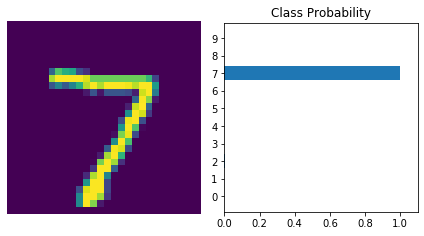

In [12]:
%matplotlib inline
import helper

images, labels = next(iter(testloader))
img = images[0] #.view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model1.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

In [13]:
from torch.utils.data import SubsetRandomSampler 

def get_trainloader_slice(i, slice_size):    
    train_indices = range(int(i*slice_size), int((i+1)*slice_size))
    trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=False, sampler=SubsetRandomSampler(train_indices))
    return trainloader

models = list()
train_size = len(mnist_trainset)
n_teachers = 20
n_slices = n_teachers  #n_slices is deprecated
slice_size = train_size / n_slices

for i in range(n_slices):
    print('Training slice ', i, '...')
    new_model = Classifier()
    new_trainloader = get_trainloader_slice(i, slice_size)
    new_model.train_and_test(new_trainloader, testloader, 1)
    models.append(new_model)    
len(models)    

Training slice  0 ...
Epoch 1
Epoch: 1/1  Training Loss: 1.153  Test Loss: 0.518  Test Accuracy: 0.851
Training slice  1 ...
Epoch 1
Epoch: 1/1  Training Loss: 1.089  Test Loss: 0.487  Test Accuracy: 0.864
Training slice  2 ...
Epoch 1
Epoch: 1/1  Training Loss: 1.179  Test Loss: 0.535  Test Accuracy: 0.837
Training slice  3 ...
Epoch 1
Epoch: 1/1  Training Loss: 1.109  Test Loss: 0.487  Test Accuracy: 0.857
Training slice  4 ...
Epoch 1
Epoch: 1/1  Training Loss: 1.252  Test Loss: 0.506  Test Accuracy: 0.860
Training slice  5 ...
Epoch 1
Epoch: 1/1  Training Loss: 1.212  Test Loss: 0.507  Test Accuracy: 0.850
Training slice  6 ...
Epoch 1
Epoch: 1/1  Training Loss: 1.119  Test Loss: 0.471  Test Accuracy: 0.870
Training slice  7 ...
Epoch 1
Epoch: 1/1  Training Loss: 1.146  Test Loss: 0.501  Test Accuracy: 0.854
Training slice  8 ...
Epoch 1
Epoch: 1/1  Training Loss: 1.146  Test Loss: 0.472  Test Accuracy: 0.864
Training slice  9 ...
Epoch 1
Epoch: 1/1  Training Loss: 1.132  Test Loss

20

In [14]:
n_testset = len(mnist_testset)
with torch.no_grad():    
    private_label_matrix = torch.zeros(len(models), n_testset).long()
    for i in range(len(models)):
        model = models[i]
        predictions = model.predict_dataset(testloader)        
        private_label_matrix[i] = predictions
    print(private_label_matrix.shape)

torch.Size([20, 10000])


In [15]:
import numpy as np
def getLaplacianNoise(sensitivity, epsilon):
    b = sensitivity / epsilon
    return np.random.laplace(0, b, 1)

In [16]:
dp_labels = torch.zeros(n_testset).long()
epsilon = 0.1
sensitivity = 1
nondp_labels = torch.zeros(n_testset).long()
for i in range(n_testset):
    private_labels = private_label_matrix[:,i].bincount(minlength=10)
    
    # print(private_labels.tolist())
    noised_labels = list(map(lambda l: l + getLaplacianNoise(sensitivity, epsilon)[0], private_labels.tolist()))
  
    dp_labels[i] = int(np.argmax(noised_labels))
    nondp_labels[i] = int(np.argmax(private_labels.tolist()))

dp_labels
nondp_labels

tensor([7, 2, 1,  ..., 4, 5, 6])

In [17]:
## Test accuracy
equals = dp_labels == mnist_testset.targets
accuracy = torch.mean(equals.type(torch.FloatTensor))    
print('DP model accuracy: ', accuracy)


DP model accuracy:  tensor(0.3969)


In [18]:
from torch.utils.data import TensorDataset, DataLoader
# mnist_testset.test_data.shape
# torch.Size([10000, 28, 28])
images = mnist_testset.test_data.float() / 255  # Needed for normalization

dataset = TensorDataset(images, dp_labels.long())
dploader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
dpmodel = Classifier()
dpmodel.train_and_test(dploader, testloader, 8)


C:\Users\edgarin\.conda\envs\pysyft-env\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Epoch 1
Epoch: 1/8  Training Loss: 2.096  Test Loss: 1.325  Test Accuracy: 0.811
Epoch 2
Epoch: 2/8  Training Loss: 2.008  Test Loss: 1.272  Test Accuracy: 0.840
Epoch 3
Epoch: 3/8  Training Loss: 1.985  Test Loss: 1.243  Test Accuracy: 0.836
Epoch 4
Epoch: 4/8  Training Loss: 1.973  Test Loss: 1.231  Test Accuracy: 0.838
Epoch 5
Epoch: 5/8  Training Loss: 1.960  Test Loss: 1.228  Test Accuracy: 0.831
Epoch 6
Epoch: 6/8  Training Loss: 1.941  Test Loss: 1.220  Test Accuracy: 0.827
Epoch 7
Epoch: 7/8  Training Loss: 1.930  Test Loss: 1.188  Test Accuracy: 0.827
Epoch 8
Epoch: 8/8  Training Loss: 1.913  Test Loss: 1.199  Test Accuracy: 0.818


In [19]:
from syft.frameworks.torch.differential_privacy import pate

data_dep_eps, data_ind_eps = pate.perform_analysis(
    teacher_preds=private_label_matrix.numpy().astype(int), 
    indices=nondp_labels.numpy().astype(int), 
    noise_eps=0.001, 
    delta=1e-5,
    moments=100
)

# assert data_dep_eps <= data_ind_eps

In [20]:
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 0.9797052277070929
Data Dependent Epsilon: 0.9797052277071728
